In [273]:
import pandas as pd
import numpy as np
import chart_studio.plotly as py
import plotly.colors
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [344]:
# Reading attendance data
df_frequentation = pd.read_csv('data/frequentation-gares.csv', sep=';')
# Reading train station data
df_gares = pd.read_csv('data/referentiel-gares-voyageurs.csv', sep=';')
df = df_gares.merge(
    right=df_frequentation, 
    left_on='Code UIC', 
    right_on='Code UIC complet', 
    how='inner')

# Reading found items data
df_items = pd.read_csv('data/objets-trouves-restitution.csv', sep=';')
df = df.merge(df_items, on='Code UIC', how='right')

In [345]:
# Filtering by date
df['Date'] = pd.to_datetime(df.Date, utc=True).dt.tz_convert('Europe/Paris')

In [346]:
df = df.loc[(df.Date.dt.year >= 2015) & (df.Date.dt.year <= 2018)]

df['Passengers'] =(df['Total Voyageurs 2018'] 
                    + df['Total Voyageurs 2017'] 
                    + df['Total Voyageurs 2016'] 
                    + df['Total Voyageurs 2015'])

df = (df.groupby(by="Intitulé gare")
        .agg({'Longitude WGS84': 'first',
              'Latitude WGS84': 'first',
              'Nature d\'objets': len,
              'Passengers': 'first'})
        .rename(columns={'Nature d\'objets': 'item_count'})
)

In [347]:
df['count_per_100kpax'] = df.item_count / df.Passengers * 1e5
df = df.sort_values(by='count_per_100kpax', ascending=False)

df = df[df.item_count >= 10]
df['group'] = pd.qcut(df['count_per_100kpax'], q=np.linspace(0, 1, 6))

In [348]:
df.sort_values('count_per_100kpax')

,Longitude WGS84,Latitude WGS84,item_count,Passengers,count_per_100kpax,group
Intitulé gare,,,,,,
Versailles Rive Droite,2.134752,48.809653,39,21309519.0,0.183017,"(0.182, 3.623]"
Poissy,2.041368,48.932901,80,43120958.0,0.185525,"(0.182, 3.623]"
Cergy le Haut,2.011872,49.048493,55,26956324.0,0.204034,"(0.182, 3.623]"
Saint-Cloud,2.216870,48.845410,69,33312044.0,0.207132,"(0.182, 3.623]"
Conflans-Sainte-Honorine,2.097830,48.996460,91,18585957.0,0.489617,"(0.182, 3.623]"
...,...,...,...,...,...,...
Quimper,-4.092103,47.994455,4629,3700023.0,125.107330,"(24.664, 323.36]"
Brest,-4.478903,48.388110,8549,6716665.0,127.280429,"(24.664, 323.36]"
Cherbourg,-1.621515,49.633505,2934,2236652.0,131.178207,"(24.664, 323.36]"


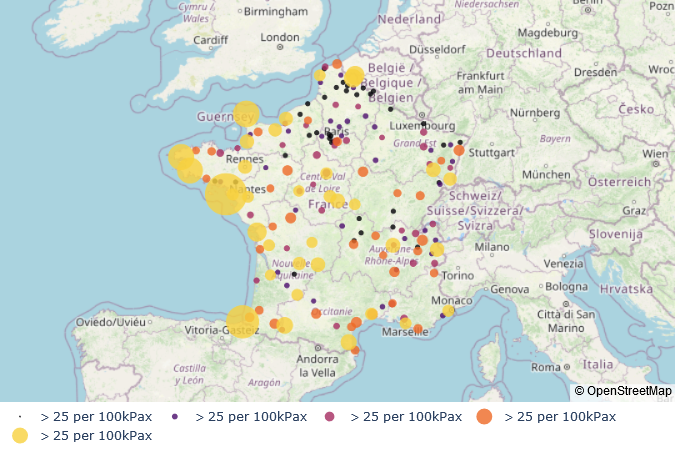

In [351]:
# Map
fig = go.Figure()
colors = plotly.colors.sequential.Inferno

for i, group in enumerate(df.group.cat.categories):
    df_sub = df[df.group == group]
    fig.add_trace(go.Scattermapbox(
            lat=df_sub['Latitude WGS84'], 
            lon=df_sub['Longitude WGS84'],
            text=df_sub.index,
            marker=dict(
                color=colors[2*i],
                size=df_sub['count_per_100kpax'],
                sizemin=3,
                sizeref=.35,
                sizemode='area',
                opacity=.8,
            ),
            meta=df_sub['item_count'],
            hovertemplate="%{text}" + "<br>" 
                            + "Found items: %{meta}" + "<br>" 
                            + "Per 100kPax: " + "%{marker.size:.1f}",
            name=f'> {cat.left:.0f} per 100kPax',          
    ))
    
fig.update_layout(
    mapbox_style="open-street-map",
    #title='Passengers per french train station in 2018',
    margin={'l': 0, 'r': 0, 't': 0, 'b': 0},
    mapbox=dict(
        center={'lon': 2.39, 'lat': 47.09},
        zoom=4
    ),
)

fig.update_layout(legend={'orientation': 'h', 'y': 0})

fig.show(config={'scrollZoom': True, "displayModeBar": False})

In [339]:
fig.write_html('sncf-found-items-map.html')